## Three data-driven tips on starting a profitable Airbnb business in NYC

It can be both exciting and nerve-racking to start an Airbnb business in New York City, the №1 tourist destination in the US. On one hand, you probably have heard of numerous successful stories and are eager to make your own luck. On the other hand, you may be bothered by fundamental questions, such as which property to invest in and what is a fair price for your listing.

One good way of answering those question is to look into historical listings. In this article, I will walk you through such a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). It records all Airbnb listings in NYC during the year of 2019 with details such as price and location. By analyzing it, I will try to provide **three tips to help new hosts start a profitable Airbnb business:**

1. [<span style="color:#1dacd6">Strategies to find an investment property for listing</span>](#first-bullet)
2. [<span style="color:#1dacd6">Strategies to price a listing</span>](#second-bullet)
3. [<span style="color:#1dacd6">Strategies to name/describe a listing</span>](#third-bullet)


## 0. Data Cleaning and Inspection

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import multidict as multidict
import collections
import re
import nltk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download(['punkt', 'wordnet','averaged_perceptron_tagger','stopwords']);

[nltk_data] Downloading package punkt to /Users/Baiyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Baiyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Baiyu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/Baiyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load raw data
df = pd.read_csv('./AB_NYC_2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [64]:
# inspect neighbourhood
print(df.neighbourhood_group.nunique(), df.neighbourhood_group.unique())
print(df.neighbourhood.nunique(), df.neighbourhood.unique())

5 ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
221 ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkinsville' 'Astoria' 'Clason Point' 'Eastchester' 'Kingsbridge'
 'Two Bridges' 'Queens Village' 'Rockaway B

In [78]:
# inspect price
df['price'].describe(percentiles = [0.1, 0.5, 0.9])

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
10%         49.000000
50%        106.000000
90%        269.000000
max      10000.000000
Name: price, dtype: float64

In [82]:
# inspect minimum_nights
df['minimum_nights'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.9])

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
10%          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
90%         28.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [75]:
# inspect reviews_per_month
df['reviews_per_month'].describe()

count    38843.000000
mean         1.373221
std          1.680442
min          0.010000
25%          0.190000
50%          0.720000
75%          2.020000
max         58.500000
Name: reviews_per_month, dtype: float64

In [76]:
# inspect availability_365
df['availability_365'].describe()

count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

In [83]:
# focus on reasonable listings only 
listings = df[(df.price > 0) & (df.price <= 270) & (df.availability_365>0) & (df.minimum_nights<=28)]
   
# drop personal information
listings = listings.drop('host_name', axis=1)

# fill nan
listings['reviews_per_month'].fillna(0, inplace=True)
listings.shape

(23938, 15)

In [84]:
listings.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## 1. Strategies to find an investment property for listing<a class="anchor" id="first-bullet"></a>
If you do not own a property yet, finding an investment property might be your first step. My strategies of finding an investment property is to answer three questions below: Which neighbourhoods are popular? Which neighbourhoods are expensive? Do people usually list an entire apartment or a private room?

### 1.1 Which neighbourhoods are popular (more listing count)?

Brooklyn         10333
Manhattan         8636
Queens            3820
Bronx              848
Staten Island      301
Name: neighbourhood_group, dtype: int64


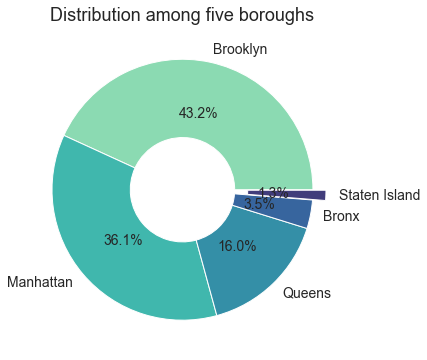

In [85]:
# borough-wise distribution
borough_distribution = listings.neighbourhood_group.value_counts()
print(borough_distribution)

plt.figure(figsize = (8,6))
plt.pie(borough_distribution, autopct="%.1f%%", labels = borough_distribution.index, \
        colors = sns.color_palette('mako_r'), explode = [0,0,0,0,0.1], \
        textprops={'fontsize': 14}, wedgeprops=dict(width=0.6))
plt.title('Distribution among five boroughs', fontsize = 18)
plt.savefig('images/BoroughDistribution.png', bbox_inches = 'tight');

In [129]:
# find the borough corresponds to each neighbourhood
borough_df = listings.groupby(['neighbourhood_group','neighbourhood'])['id'].count().reset_index()
borough_lut = {}
for i in range(borough_df.shape[0]):
    borough_lut[borough_df.iloc[i]['neighbourhood']] = borough_df.iloc[i]['neighbourhood_group']

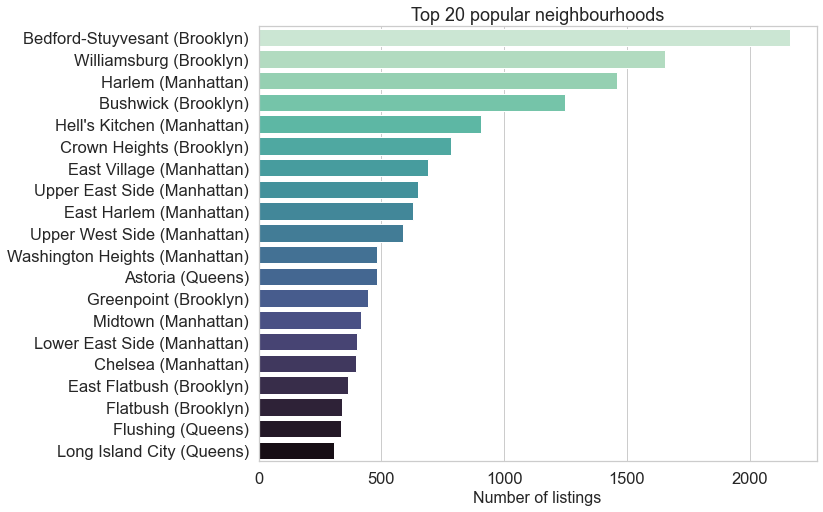

In [108]:
# top 20 popular neighbourhoods
popular_neighbourhoods = listings.neighbourhood.value_counts()[:20]
listing_counts = popular_neighbourhoods.values
popular_neighbourhood_names = ['{} ({})'.format(n,borough_lut[n]) for n in popular_neighbourhoods.index]

plt.figure(figsize = (10,8))
sns.barplot(y = popular_neighbourhood_names, x = listing_counts, palette='mako_r')
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
plt.xlabel("Number of listings", fontsize = 16)
plt.title('Top 20 popular neighbourhoods', fontsize = 18);
plt.savefig('images/PopularNeighbourhoods.png', bbox_inches = 'tight');

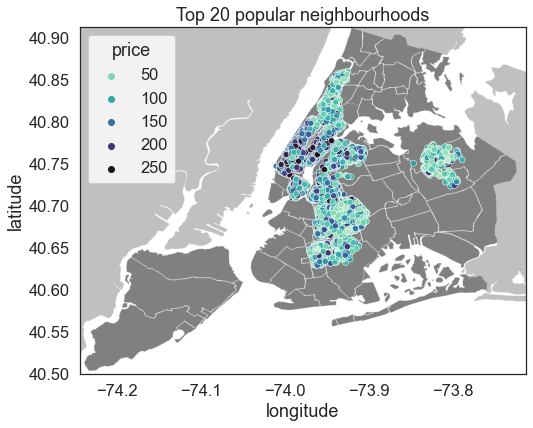

In [110]:
# might be fun to also visualize those popular neighbourhood on the map
sub = listings[listings['neighbourhood'].isin(popular_neighbourhoods.index)]

# show NYC map
nyc_img = mpimg.imread('images/Neighbourhoods_New_York_City_Map.png')
plt.figure(figsize=(8,10))
plt.imshow(nyc_img,zorder=0,extent=[listings.longitude.min(), listings.longitude.max(), \
                                    listings.latitude.min(),listings.latitude.max()])

# overlay scatter plot
sns.scatterplot(data = sub, x = 'longitude', y = 'latitude', hue = 'price', palette='mako_r')
sns.set_style('white')
plt.title('Top 20 popular neighbourhoods', fontsize = 18)
plt.savefig('images/PopularNeighbourhoodsMap.png', bbox_inches = 'tight');

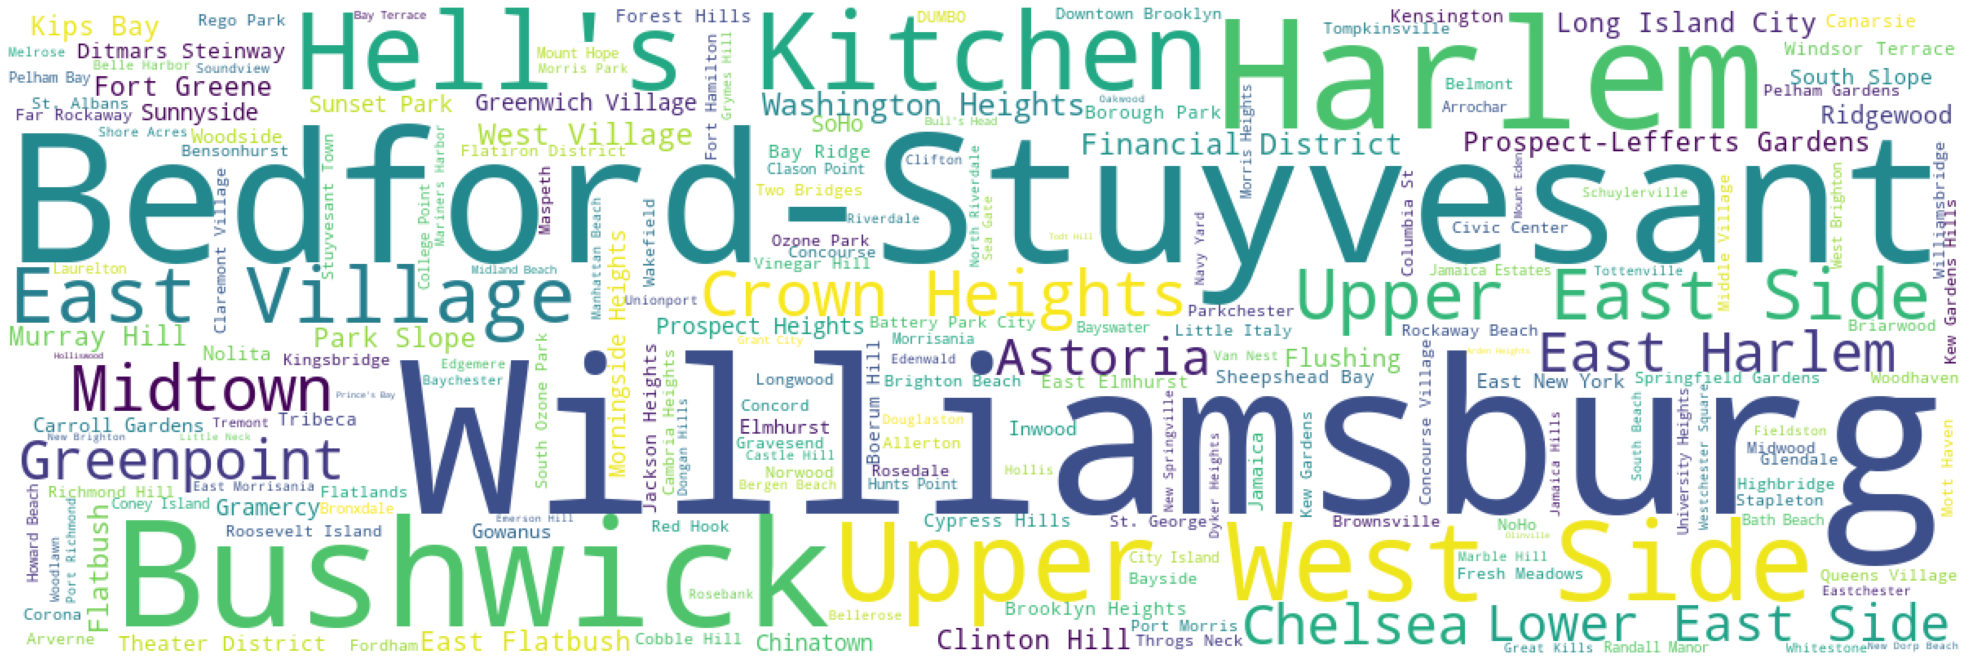

In [30]:
# a frequency-based word cloud of neighbourhoods
neighbourhood_dict = dict(df['neighbourhood'].value_counts().apply(lambda x:int(x)))
fullTermsDict = multidict.MultiDict()
for key in neighbourhood_dict:
    fullTermsDict.add(key, neighbourhood_dict[key])

plt.figure(figsize = (36,12))
neighbourhood_dict = df['neighbourhood'].value_counts
wordcloud = WordCloud(
                          background_color='white',
                          width=1200,
                          height=400
                         ).generate_from_frequencies(fullTermsDict)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('images/WordCloud.png', bbox_inches = 'tight');

### 1.2 Which neighbourhoods are expensive (higher listing price)?

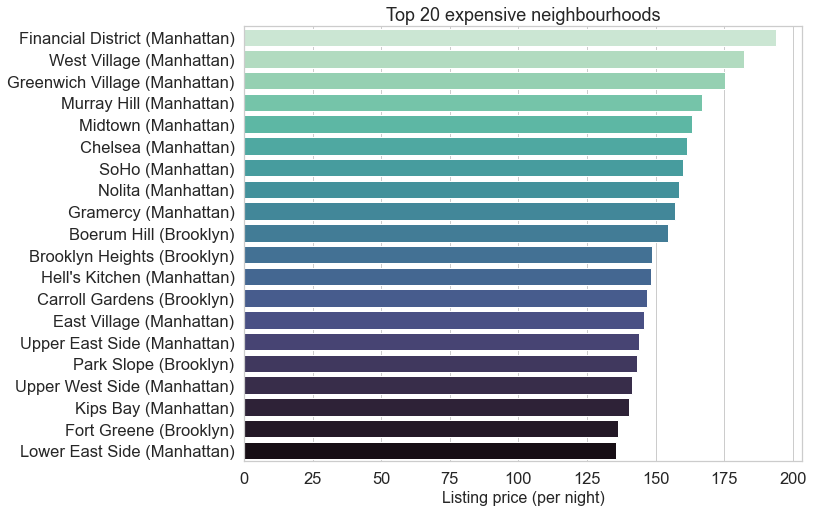

In [112]:
# top 20 expensive neighbourhoods with more than 50 listings
mask = listings.groupby('neighbourhood')['neighbourhood'].transform('count')>50
expensive_neighbourhoods = listings[mask].groupby('neighbourhood')['price'].mean().sort_values(ascending=False)[:20]
listing_avg_price = expensive_neighbourhoods.values
expensive_neighbourhood_names = ['{} ({})'.format(n,borough_lut[n]) for n in expensive_neighbourhoods.index]

plt.figure(figsize = (10,8))
sns.barplot(y = expensive_neighbourhood_names, x = listing_avg_price, palette='mako_r')
sns.set_style('whitegrid')
plt.xlabel("Listing price (per night)", fontsize = 16)
plt.ylabel("")
plt.title('Top 20 expensive neighbourhoods', fontsize = 18)
plt.savefig('images/ExpensiveNeighbourhoods.png', bbox_inches = 'tight');

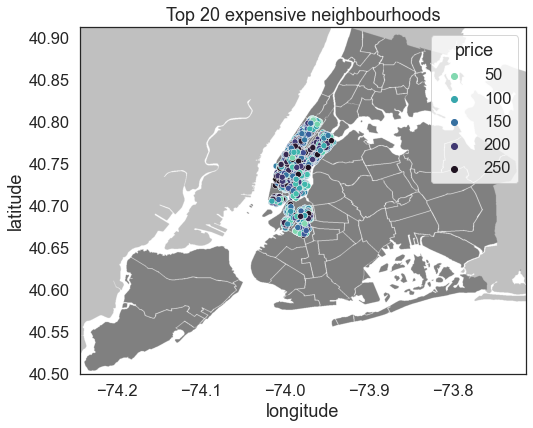

In [114]:
# let's also visualize those pricey neighbourhood on the map
sub = listings[listings['neighbourhood'].isin(expensive_neighbourhoods.index)]

# show NYC map
plt.figure(figsize=(8,10))
plt.imshow(nyc_img,zorder=0,extent=[listings.longitude.min(), listings.longitude.max(), \
                                    listings.latitude.min(),listings.latitude.max()])

# overlay scatter plot
sns.scatterplot(data = sub, x = 'longitude', y = 'latitude', hue = 'price', palette='mako_r')
sns.set_style('white')
plt.title('Top 20 expensive neighbourhoods')
plt.savefig('images/ExpensiveNeighbourhoodsMap.png', bbox_inches = 'tight');

In [94]:
# neighbourhoods that are both popular and pricey
print("Both popular and expensive:")
for neighbourhood in np.intersect1d(popular_neighbourhoods.index, expensive_neighbourhoods.index):
    print('-',neighbourhood)

Both popular and expensive:
- Chelsea
- East Village
- Hell's Kitchen
- Lower East Side
- Midtown
- Upper East Side
- Upper West Side


### 1.3 Entire apartment or private room?

Private room       12540
Entire home/apt    10645
Shared room          753
Name: room_type, dtype: int64


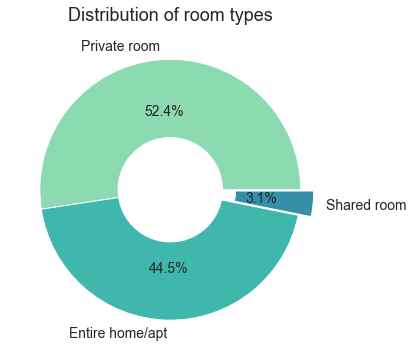

In [115]:
# room_type distribution
roomtype_distribution = listings.room_type.value_counts()
print(roomtype_distribution)

plt.figure(figsize = (8,6))
plt.pie(roomtype_distribution, autopct="%.1f%%", labels = roomtype_distribution.index, \
        colors = sns.color_palette('mako_r'), explode = [0,0,0.1], \
        textprops={'fontsize': 14}, wedgeprops=dict(width=0.6));
plt.title('Distribution of room types', fontsize = 18)
plt.savefig('images/RoomTypeDistribution.png', bbox_inches = 'tight');

### 1.4 Summary 
We have found 7 neighbourhoods that are both popular and expensive, which might be an easy start for new Airbnb hosts like you. We also found that half of the listings in NYC are offering just a private room, so that you can still become an Airbnb host if all you could afford is an extra bedroom (or even a living room).

However, keep in mind that popular neighbourhoods could also mean intense competitions between hosts, and expensive neighbourhoods could mean higher carrying cost of the property. To follow the trend and become a host in those neighbourhoods or to fill the niche and find a less-represented neighbourhood? That's your own decision.

## 2. Strategies to price a listing<a class="anchor" id="second-bullet"></a>
My strategy is to train a regression model from past listings, and use the model to price a new listing.

In [122]:
# only use popular listings (with resonable amount of reviews) for regression model
listings_popular = listings[listings['reviews_per_month']>=0.72]
listings_popular.shape

(15138, 15)

In [102]:
# prepare X and y
X = listings_popular[['neighbourhood_group', 'neighbourhood', 'room_type', 'minimum_nights',\
                      'number_of_reviews', 'reviews_per_month', 'availability_365']]
X_enc = pd.get_dummies(data = X, columns = ['neighbourhood_group','neighbourhood','room_type'], \
                             prefix = ['nbg','nb','rt']) # encode categorical features
y = listings_popular['price']

In [103]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(12110, 222) (12110,) (3028, 222) (3028,)


In [126]:
# train a random forest classifier

# initiate classifier
model = RandomForestRegressor(random_state = 42)

# grid search with cross validation
gridParams = {
    'n_estimators': [300, 400, 500],
    'max_features': [20,35,50],
    'min_samples_leaf': [1, 2, 3], 
    'max_depth': [None,16,32,48],
    }
grid = GridSearchCV(model, gridParams, scoring = 'neg_mean_squared_error', verbose=3, cv=5, n_jobs=1)
grid.fit(X_train, y_train)

# print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1298.184 total time=  10.4s
[CV 2/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1267.887 total time=   9.6s
[CV 3/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1319.408 total time=   8.7s
[CV 4/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1338.082 total time=   9.0s
[CV 5/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1318.214 total time=   9.2s
[CV 1/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1295.336 total time=  12.1s
[CV 2/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1268.673 total time=  11.7s
[CV 3/5] END max_depth=None, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1317.

[CV 4/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=400;, score=-1324.713 total time=  10.5s
[CV 5/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=400;, score=-1292.771 total time=  10.0s
[CV 1/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1277.202 total time=  11.7s
[CV 2/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1248.788 total time=  11.5s
[CV 3/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1299.190 total time=  11.7s
[CV 4/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1323.604 total time=  11.7s
[CV 5/5] END max_depth=None, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1291.597 total time=  11.8s
[CV 1/5] END max_depth=None, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1278.122 total time=   6.4s
[CV 2/5] END max_depth=None, max_feature

[CV 3/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1346.320 total time=   6.4s
[CV 4/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1368.943 total time=   8.2s
[CV 5/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=300;, score=-1339.679 total time=   6.2s
[CV 1/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1309.273 total time=   6.7s
[CV 2/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1299.895 total time=   6.9s
[CV 3/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1346.566 total time=   7.1s
[CV 4/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1368.864 total time=   6.7s
[CV 5/5] END max_depth=16, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1340.772 total time=   9.4s
[CV 1/5] END max_depth=16, max_features=20, min_samples_

[CV 3/5] END max_depth=16, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1316.429 total time=  10.2s
[CV 4/5] END max_depth=16, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1340.653 total time=  10.4s
[CV 5/5] END max_depth=16, max_features=35, min_samples_leaf=2, n_estimators=500;, score=-1301.827 total time=   9.6s
[CV 1/5] END max_depth=16, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1289.033 total time=   5.8s
[CV 2/5] END max_depth=16, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1272.195 total time=   5.4s
[CV 3/5] END max_depth=16, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1321.605 total time=   5.6s
[CV 4/5] END max_depth=16, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1343.327 total time=   5.7s
[CV 5/5] END max_depth=16, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1308.343 total time=   5.5s
[CV 1/5] END max_depth=16, max_features=35, min_samples_

[CV 3/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1302.585 total time=  14.0s
[CV 4/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1322.211 total time=  15.1s
[CV 5/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=400;, score=-1302.689 total time=  15.9s
[CV 1/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1282.510 total time=  15.0s
[CV 2/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1246.573 total time=  15.8s
[CV 3/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1301.840 total time=  14.6s
[CV 4/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1323.978 total time=  15.3s
[CV 5/5] END max_depth=32, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1301.764 total time=  15.5s
[CV 1/5] END max_depth=32, max_features=20, min_samples_

[CV 3/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1304.472 total time=   7.2s
[CV 4/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1327.625 total time=   6.2s
[CV 5/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=300;, score=-1290.983 total time=   6.2s
[CV 1/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1276.894 total time=   8.3s
[CV 2/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1250.800 total time=   9.1s
[CV 3/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1304.814 total time=   8.2s
[CV 4/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1327.125 total time=   8.4s
[CV 5/5] END max_depth=32, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1293.085 total time=   9.2s
[CV 1/5] END max_depth=32, max_features=35, min_samples_

[CV 3/5] END max_depth=48, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1318.323 total time=  15.3s
[CV 4/5] END max_depth=48, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1333.393 total time=  16.6s
[CV 5/5] END max_depth=48, max_features=20, min_samples_leaf=1, n_estimators=500;, score=-1320.526 total time=  15.3s
[CV 1/5] END max_depth=48, max_features=20, min_samples_leaf=2, n_estimators=300;, score=-1282.684 total time=   5.7s
[CV 2/5] END max_depth=48, max_features=20, min_samples_leaf=2, n_estimators=300;, score=-1264.260 total time=   5.4s
[CV 3/5] END max_depth=48, max_features=20, min_samples_leaf=2, n_estimators=300;, score=-1308.321 total time=   6.5s
[CV 4/5] END max_depth=48, max_features=20, min_samples_leaf=2, n_estimators=300;, score=-1334.505 total time=   5.7s
[CV 5/5] END max_depth=48, max_features=20, min_samples_leaf=2, n_estimators=300;, score=-1292.935 total time=   5.8s
[CV 1/5] END max_depth=48, max_features=20, min_samples_

[CV 3/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1301.816 total time=   8.4s
[CV 4/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1324.767 total time=   8.3s
[CV 5/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=400;, score=-1289.882 total time=   8.1s
[CV 1/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=500;, score=-1276.955 total time=  10.3s
[CV 2/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=500;, score=-1253.257 total time=  10.3s
[CV 3/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=500;, score=-1300.678 total time=  10.4s
[CV 4/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=500;, score=-1324.746 total time=  10.4s
[CV 5/5] END max_depth=48, max_features=35, min_samples_leaf=3, n_estimators=500;, score=-1291.192 total time=  10.4s
[CV 1/5] END max_depth=48, max_features=50, min_samples_

In [127]:
# test the classifier. test with both training and test data to evaluate overfitting
y_pred_train = grid.predict(X_train)
mse_train = mean_squared_error(y_pred_train, y_train)

y_pred_test = grid.predict(X_test)
mse_test = mean_squared_error(y_pred_test, y_test)

print('MSE of training data: {:.02f}\nMSE of test data: {:.02f}'.format(mse_train, mse_test))

MSE of training data: 675.98
MSE of test data: 1301.57


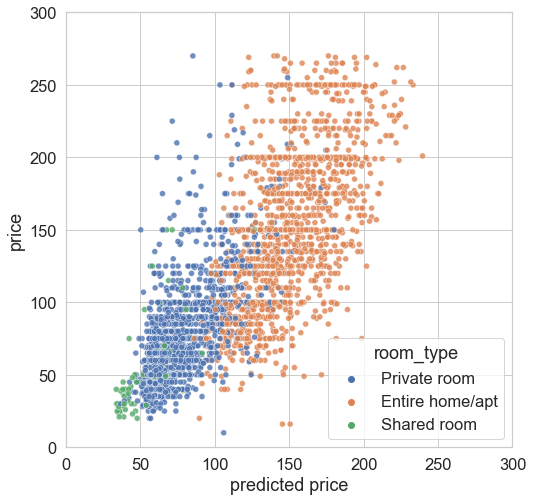

In [128]:
# visualize the prediction result with un-encoded data
_, temp, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)
test_unenc = temp.copy()
test_unenc['predicted_price'] = y_pred_test
test_unenc['price'] = y_test

plt.figure(figsize=(8, 8));
sns.scatterplot(data = test_unenc, x = 'predicted_price', y = 'price', hue = 'room_type', alpha = 0.8)
sns.set_style('whitegrid')
plt.xlabel('predicted price')
plt.ylabel('price')
plt.xlim((0, 300))
plt.ylim((0, 300))
plt.savefig('images/PredictionVSTruth.png', bbox_inches = 'tight');

In general, the scatter points lie along the diagonal line of y = x. There are more outliers in the upper left corner than the lower right corner, meaning that the model tend to underestimate rather than overestimating listing prices. This is probably because some factors that can raise up the price are not included in the regressor, such as extra number of guests an apartment/room can host, availability of the listing during Christmas, view of Empire State Building from a private deck, and proximity to subway stations.

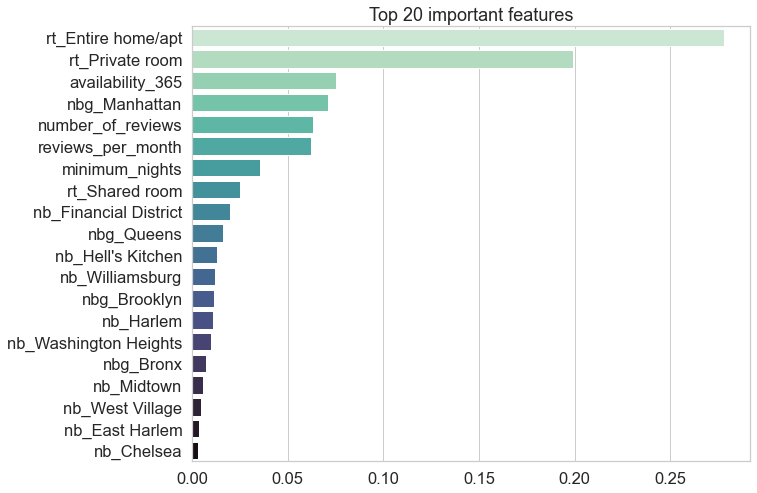

In [118]:
# feature importance
feature_importances = grid.best_estimator_.feature_importances_

features_sorted = X_test.columns[feature_importances.argsort()][::-1]
feature_importances_sorted = sorted(feature_importances)[::-1]

plt.figure(figsize=(10,8));
sns.barplot(y=features_sorted[:20],x=feature_importances_sorted[:20], palette = 'mako_r')
sns.set_style('whitegrid')
plt.title('Top 20 important features')
plt.savefig('images/ImportantFeatures.png', bbox_inches = 'tight');

## 3. Strategies to name/describe a listing<a class="anchor" id="third-bullet"></a>
How do hosts attract guests with listing titles? Let's find out by counting the frequency of words in titles (Column `name`). The titles were first preprocessed into "tokens" using a customized function `tokenize`.

In [119]:
def tokenize(text):
    '''
    Tokenize the text by removing puctuation, normalizing case, splitting by space, removing stop words, 
    lemmatizing, and stemming
    Args:
        text (str): a message 
    Returns:
        tokens (list of str): tokens
    '''
    # replace punctuations with space and normalize all letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize 
    tokens = word_tokenize(text)  
    
    # lemmatize, stem and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens if word not in stop_words]
    return tokens

In [120]:
# only use popular listings (with resonable amount of reviews) for title analysis
counter = collections.Counter()
for name in listings_popular['name']:
    tokens = tokenize(name)
    for token in tokens:
        counter[token] += 1

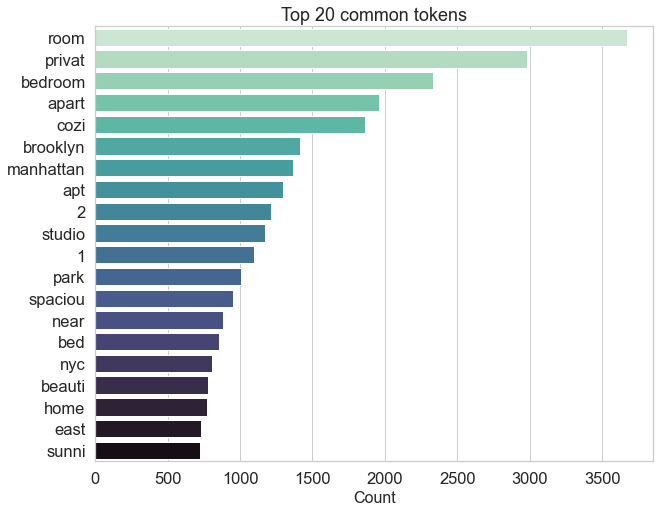

In [121]:
# plot top 20 common tokens in the name of listings
popular_tokens,counts = zip(*counter.most_common(20))
plt.figure(figsize = (10,8))
sns.barplot(y = list(popular_tokens), x = list(counts), palette='mako_r')
sns.set_style('whitegrid')
plt.xlabel("Count", fontsize = 16)
plt.title('Top 20 common tokens', fontsize = 18)
plt.savefig('images/PopularTokens.png', bbox_inches = 'tight');

These tokens can be divided into four categories: 
- tokens that describe the room type (bedroom, apart, studio, home, etc.)
- tokens that describe the location (brooklyn, manhattan, nyc, etc.)
- tokens that describe amenities (park)
- tokens that describe distinguishing features (privat, cozi, spaciou, etc.).